# Policy Gradient with gym-MiniGrid
> In this session, it will show the pytorch-implemented Policy Gradient in Gym-MiniGrid Environment.  Through this, you will know how to implement Vanila Policy Gradient (also known as REINFORCE), and test it on open source RL environment.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Reinforcement Learning]
- image: 

## Basic Jupyter Setting

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup the environment
Gridworld is widely used in RL environment. [Gym-MiniGrid](https://github.com/maximecb/gym-minigrid) is custom GridWorld environment of OpenAI [gym](https://github.com/openai/gym) style. Before dive in this environment, you need to install both of them.
```
pip install gym
pip install gym-minigrid 
```
At first, Let's look at some frames of MiniGrid.

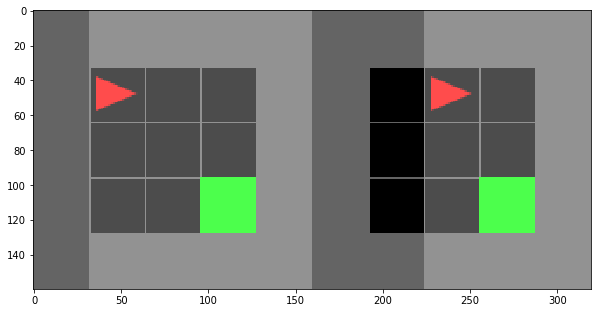

In [2]:
import gym
import gym_minigrid

env = gym.make('MiniGrid-Empty-5x5-v0')
env.reset()
before_img = env.render('rgb_array')
action = env.actions.forward
obs, reward, done, info = env.step(action)
after_img = env.render('rgb_array')

plt.imshow(np.concatenate([before_img, after_img], 1));

This is the example of `MiniGrid-Empty-5x5-v0` environment. There are some blank cells, and gray obstacle which the agent cannot pass it. And the green cell is the goal to reach. The ultimate goal of this environment (and most of RL problem) is to find the optimal policy with highest reward. In this case, well-trained agent should find the optimal path to reach the goal.

Let's move to more larger environment `MiniGrid-Empty-8x8-v0`, and find the information what we can get.

Observation: {'image': array([[[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]]], dtype=uint8), 'direction': 1, 'm

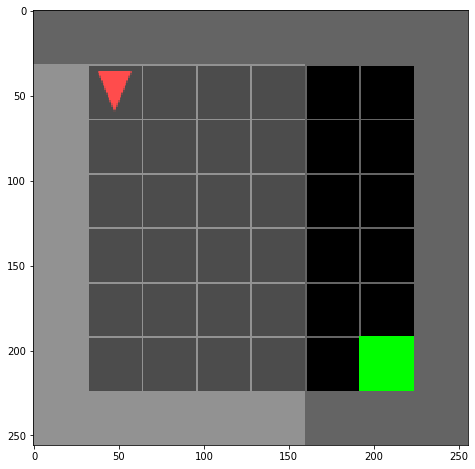

In [11]:
# Make a new environment MiniGrid-Empty-8x8-v0
env = gym.make('MiniGrid-Empty-8x8-v0')

# Reset the environment
env.reset()

# Select the action right (sample action)
action = env.actions.right

# Take a step in the environment and store it in appropriate variables
obs, reward, done, info = env.step(action)

# Render the current state of the environment
img = env.render('rgb_array')

print('Observation:', obs)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)
print('Image shape:', img.shape)
plt.imshow(img);

As the agent take an action, environment (MiniGrid) will be changed with respect to action. 
If the agent want to find the optimal path, the agent should notice the difference between current state and next state while taking an action. To help this, the environment generates next state, reward, and terminal flags.

Some helper function offers to render the sample action in Jupyter Notebook.

In [12]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

To help agent training easily, MiniGrid offers `FlatObsWrapper` for flattening observation (in other words, 1D array)

In [13]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

max_env_steps = 50

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        flattened_grid = full_grid.ravel()
        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

So It's time to run with sample action!

Observation: [10  0  1  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  8  1  0] , Observation Shape:  (108,)
Reward: 0
Done: False
Info: {}
Image shape: (256, 256, 3)


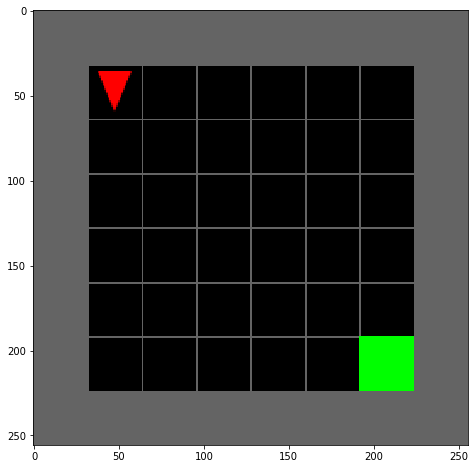

In [14]:
# Convert MiniGrid Environment with Flat Observable 
env = FlatObsWrapper(gym.make('MiniGrid-Empty-8x8-v0'))

# Reset the environment
env.reset()

# Select the action right
action = env.actions.right

# Take a step in the environment and store it in appropriate variables
obs, reward, done, info = env.step(action)

# Render the current state of the environment
img = env.render('rgb_array')
################# YOUR CODE ENDS HERE ###############################

print('Observation:', obs, ', Observation Shape: ', obs.shape)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)
print('Image shape:', img.shape)
plt.imshow(img);

As you can see it in observation, the dimension of observation is changed from 2D to 1D. Using this observation, we will make some kind of neural network to help agent to notice the observation. Let's check the real-time video of random movement.

In [15]:
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

Currently, OpenAI Gym offers several utils to help understanding the training progress. Monitor is one of that tool to log the history data. If we set the rendering option to `rgb_array`, the video data will be stored in specific path. (Maybe it requires some additional apps such as ffmpeg)

In [17]:
# Random agent - we only use it in this cell for demonstration
class RandPolicy:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def act(self, *unused_args):
        return self.action_space.sample(), None



At first, we want check the operation of environment-agent interaction. To do this, Random Policy that generates the "random action" is defined. This policy just generates random action from pre-defined action space. And then run it. 
> Note that `pytorch_policy` flag is set to `False` as a default. But to implement the policy gradient, the gradient calculation is required, and pytorch will be used.

In [18]:
# This function plots videos of rollouts (episodes) of a given policy and environment
def log_policy_rollout(policy, env_name, pytorch_policy=False):
    # Create environment with flat observation
    env = gen_wrapped_env(env_name)

    # Initialize environment
    observation = env.reset()

    done = False
    episode_reward = 0
    episode_length = 0

    # Run until done == True
    while not done:
      # Take a step
        if pytorch_policy: 
            observation = torch.tensor(observation, dtype=torch.float32)
            action = policy.act(observation)[0].data.cpu().numpy()
        else:
            action = policy.act(observation)[0]
        observation, reward, done, info = env.step(action)

        episode_reward += reward
        episode_length += 1

    print('Total reward:', episode_reward)
    print('Total length:', episode_length)

    env.close()
    
    show_video()

# Test that the logging function is working
test_env_name = 'MiniGrid-Empty-8x8-v0'
rand_policy = RandPolicy(FlatObsWrapper(gym.make(test_env_name)).action_space)
log_policy_rollout(rand_policy, test_env_name)

Total reward: 0
Total length: 50


That's the agent work with Random Policy.